In [50]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [51]:
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
import importlib
import models
importlib.reload(models)
from models import LiteralListener, LiteralSpeaker, PragmaticListener, CaptionEncoder, CaptionGenerator, PytorchModel, ColorEncoder
# from evaluation import score_model
from experiment import FeatureHandler#, evaluate_model
from scipy import stats # for pearsonr, spearmanr

In [52]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [53]:
eval_df = None
def score_model(test_data, scores, regressor=stats.pearsonr):
    """
    Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
    between the scores of the individual games and the scores from the model
    """
    global eval_df
    relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq", "condition"]
#     if speaker == Speaker.BY_WORKER_ID:
#         relevant_columns.append(Speaker.BY_WORKER_ID.value)

# #     if score == Score.COMPOSITE:
#         # no support for this yet but probably also need:
#         relevant_columns.extend(["contents", "clkTime", "msgTime"])

    eval_df = test_data.data[relevant_columns].copy()
    eval_df["model_scores"] = scores # why we need scores to be in same order as rows

    #true_scores = eval_df.groupby("gameid").numOutcome.mean()
    true_scores = eval_df.groupby("gameid").numOutcome.mean()


#     if score == score.SIMPLE:
#         # calculate scores as the mean of the number of successful utterances
#         # a speaker has
#         true_scores = eval_df.groupby(speaker.value).numOutcome.mean()
#     else:
#         true_scores = calculate_scores(eval_df, score)

    # calculate a model score
    #model_scores = eval_df.groupby("gameid").model_scores.mean()
    model_scores = eval_df.groupby("gameid").model_scores.mean()

    result = regressor(true_scores, model_scores)
    return result, true_scores, model_scores

In [54]:
def evaluate_model(assess_data, feature_handler, model, predictions_to_scores, model_scorer=score_model,
                    feature_handler_2=None, model_scorer_kwargs={}, accuracy=True):
    assess_features = feature_handler.test_features() # ~6 sec
    if feature_handler_2 != None:
        assess_features_2 = feature_handler_2.test_features()
        assess_features = list(zip(assess_features, assess_features_2))
    assess_targets = feature_handler.test_targets()
    model_outputs =  model.predict(assess_features)
    model_scores = predictions_to_scores(model_outputs, assess_targets) # decide what the score we're going to use is
    result, true_scores_grouped, model_scores_grouped = model_scorer(assess_data, model_scores, **model_scorer_kwargs)
    print(result)

    if accuracy: # also report accuracy
        model_predictions = np.argmax(model_outputs, axis=1)
        accuracy_val = sum(model_predictions == assess_targets) / len(assess_targets)
        print("Accuracy:", accuracy_val)
        
    return assess_targets, model_outputs, model_scores, true_scores_grouped, model_scores_grouped

In [55]:
# Literal Listener v2

# Initializing featurizers
print("Initializing featurizers")
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"
# caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with other paremter files

color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

# Now we have a different target function, because we want to predict what the listener selected
def listener_click_target(data_entry, color_perm):
    # color_perm because colors are randomized
    return np.where(color_perm==data_entry.click_idx)[0]

feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=listener_click_target)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

print("Initializing model")
# model parameters
embed_dim = 100; hidden_dim = 100; color_dim= 54; # hard coded for example - 54 comes from color fourier phi




Initializing featurizers
Obtaining training features
Initializing model


In [56]:
train = False
model_file_v2 = "../model/literal_listener_listener_click_5epoch_endings_tkn.params"

model_v2 = LiteralListener(CaptionEncoder, num_epochs=30)
model_v2.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file_v2))
    model_v2.fit(train_features, train_targets)
    model_v2.save_model(model_file_v2)
else:
    print("Loading pretrained model")
    model_v2.load_model(model_file_v2)

Loading pretrained model


In [57]:
# accuracy doesn't matter too much here bc it's trained to pick listener click and tested against speaker target
print("Evaluating model - Literal Listener Listener Click\t Target: speaker target")
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score

# we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
# so we change the feature_handler's target function to do that:
feature_handler.target_fn = lambda data_entry, color_perm: np.where(color_perm == data_entry.target_idx)[0]
assess_targets_tgt_v2, model_outputs_v2, model_scores_v2, true_scores_grouped_v2, model_scores_grouped_v2 =\
    evaluate_model(dev_data, feature_handler, model_v2, output_to_score, score_model)

Evaluating model - Literal Listener Listener Click	 Target: speaker target
(0.2650323585934019, 1.7015255138608701e-06)
Accuracy: 0.711104020421187


In [58]:
import matplotlib.pyplot as plt

In [59]:
%matplotlib inline

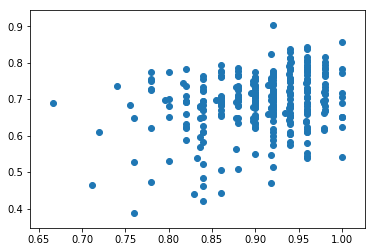

In [60]:
plt.scatter(true_scores_grouped_v2, model_scores_grouped_v2)

In [61]:
eval_scores_split = eval_df.groupby(['gameid', 'condition']).mean()

In [62]:
eval_scores_split['model_scores']

gameid  condition
0022-7  close        0.813612
        far          0.929275
        split        0.567988
0069-8  close        0.521237
        far          0.584805
        split        0.525920
0070-1  close        0.545423
        far          0.753305
        split        0.556865
0106-1  close        0.748833
        far          0.717459
        split        0.736616
0109-c  close        0.694058
        far          0.857155
        split        0.713305
0137-f  close        0.518619
        far          0.717240
        split        0.479292
0197-6  close        0.681760
        far          0.745540
        split        0.495115
0217-e  close        0.641886
        far          0.812750
        split        0.689842
0219-7  close        0.574137
        far          0.700613
        split        0.809212
0239-7  close        0.770146
        far          0.917770
        split        0.653858
                       ...   
9709-7  close        0.712712
        far          0

In [63]:
eval_scores_split['numOutcome']

gameid  condition
0022-7  close        0.933333
        far          1.000000
        split        0.882353
0069-8  close        1.000000
        far          1.000000
        split        0.882353
0070-1  close        0.687500
        far          0.941176
        split        0.705882
0106-1  close        0.937500
        far          0.941176
        split        0.764706
0109-c  close        0.882353
        far          1.000000
        split        1.000000
0137-f  close        0.882353
        far          0.941176
        split        0.937500
0197-6  close        0.875000
        far          1.000000
        split        0.882353
0217-e  close        1.000000
        far          1.000000
        split        1.000000
0219-7  close        0.647059
        far          1.000000
        split        0.941176
0239-7  close        0.941176
        far          1.000000
        split        1.000000
                       ...   
9709-7  close        0.941176
        far          1

In [64]:
eval_scores_split.index.get_level_values(1).values

array(['close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'c

In [65]:
colors = []
for cond in eval_scores_split.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

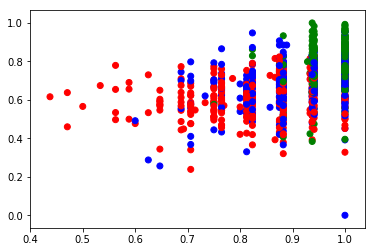

In [66]:
plt.scatter(eval_scores_split['numOutcome'], eval_scores_split['model_scores'], c=colors)
plt.show()

In [68]:
eval_scores_split['condition']

KeyError: 'condition'

In [ ]:
close_scores = eval_df[eval_df['condition'] == 'close'].groupby('gameid').mean()
split_scores = eval_df[eval_df['condition'] == 'split'].groupby('gameid').mean()
far_scores = eval_df[eval_df['condition'] == 'far'].groupby('gameid').mean()

In [ ]:
plt.scatter(close_scores['numOutcome'], close_scores['model_scores'])
plt.show()

In [ ]:
plt.hist(close_scores['numOutcome'], 10)
plt.show()

In [ ]:
plt.scatter(split_scores['numOutcome'], split_scores['model_scores'])
plt.show()

In [ ]:
plt.hist(split_scores['numOutcome'], 10)
plt.show()

In [ ]:
plt.scatter(far_scores['numOutcome'], far_scores['model_scores'])
plt.show()

In [ ]:
plt.hist(far_scores['numOutcome'], 10)
plt.show()

In [ ]:
5171*3

In [ ]:
import pandas as pd

In [ ]:
subj_analysis_df = pd.read_csv("/Users/benjaminnewman/Documents/Stanford/CS224U/projects/colors-in-context/behavioralAnalysis/humanOutput/rawCorpus/subjectInfo.csv")

In [ ]:
subj_analysis_df.head()

In [ ]:
subj_analysis_df.ratePartner.value_counts()

In [ ]:
subj_analysis_df.gameID.value_counts()

In [ ]:
overlap_vals = []
for gameid in subj_analysis_df['gameID']:
    overlap_vals.append(gameid in eval_df.gameid.values)

In [ ]:
sum(overlap_vals)/len(overlap_vals)

In [ ]:
len(overlap_vals)

In [ ]:
subj_analysis_subdf2 = subj_analysis_df[(overlap_vals)]

In [ ]:
subj_analysis_subdf.shape

In [ ]:
close_scores.shape

In [ ]:
close_games_subj = close_scores.join(subj_analysis_subdf.set_index('gameID'))

In [ ]:
close_games_subj.head()

In [ ]:
close_games_subj.ratePartner.value_counts(dropna=False)

In [ ]:
134+91+62+23

In [ ]:
rate_partner_colors = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in close_games_subj.ratePartner.values:
    rate_partner_colors.append(colmap.get(rating, 'black'))

In [ ]:
plt.scatter(close_games_subj['numOutcome'], close_games_subj['model_scores'], c=rate_partner_colors, alpha=0.7)
plt.show()

In [ ]:
split_games_subj = split_scores.join(subj_analysis_subdf.set_index('gameID'))

In [ ]:
rate_partner_colors_split = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in split_games_subj.ratePartner.values:
    rate_partner_colors_split.append(colmap.get(rating, 'black'))

In [ ]:
plt.scatter(split_games_subj['numOutcome'], split_games_subj['model_scores'], c=rate_partner_colors_split, alpha=0.7)
plt.show()

In [ ]:
far_games_subj = far_scores.join(subj_analysis_subdf.set_index('gameID'))

In [ ]:
rate_partner_colors_far = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in far_games_subj.ratePartner.values:
    rate_partner_colors_far.append(colmap.get(rating, 'black'))

In [ ]:
plt.scatter(far_games_subj['numOutcome'], far_games_subj['model_scores'], c=rate_partner_colors_far, alpha=0.7)
plt.show()

In [ ]:
far_games_subj.index.get_level_values('gameid')

In [ ]:
far_games_subj.index.get_level_values('gameid')

In [ ]:
subj_analysis_subdf[subj_analysis_subdf.gameID == "1925-1"]

In [ ]:
subj_analysis_df[subj_analysis_df.gameID == "1925-1"]["comments"][468]

In [ ]:
subj_analysis_df[subj_analysis_df.gameID == "3332-5"]

In [ ]:
subj_analysis_df[subj_analysis_df.gameID == "7286-9"]

In [ ]:
subj_analysis_df[subj_analysis_df.gameID == "0069-8"]


In [ ]:
subj_analysis_subdf.ratePartner.value_counts()

In [ ]:
subj_analysis_df[subj_analysis_df.role=='speaker'].ratePartner.value_counts()

In [ ]:
subj_analysis_df[subj_analysis_df.role=='listener'].ratePartner.value_counts()

In [ ]:
bad_gameids = subj_analysis_df[(subj_analysis_df.role=="speaker") & (subj_analysis_df.ratePartner=="not much")].gameID.values

In [ ]:
bad_gameids

In [ ]:
good_dev_data = ~dev_data.data.gameid.isin(bad_gameids)

In [ ]:
good_values = dev_data.data[good_dev_data].index.values

In [ ]:
dev_data_good = dev_data.data[good_dev_data]

In [ ]:
dev_data_good_entries = []
for val in good_values:
    dev_data_good_entries.append(dev_data.entries[val])

In [ ]:
dev_data_good_entries[:2]

In [ ]:
feature_handler_2 = FeatureHandler(train_data, dev_data_good_entries, caption_phi, color_phi)



In [ ]:
len(dev_data.data.index.values)

In [ ]:
class dummy:
    def __init__(self, data):
        self.data=data

In [ ]:
x = evaluate_model(dummy(dev_data_good), feature_handler_2, model_v2, output_to_score, score_model, accuracy=True)

In [ ]:
assess_targets_tgt_v2_good, model_outputs_v2_good, model_scores_v2_good, true_scores_grouped_v2_good, model_scores_grouped_v2_good = x

In [ ]:
plt.scatter(true_scores_grouped_v2_good, model_scores_grouped_v2_good)

In [ ]:
plt.scatter(true_scores_grouped_v2, model_scores_grouped_v2)

In [ ]:
subj_analysis_subdf2.head()

In [ ]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="not much")].score)

In [ ]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="loved")].score)

In [ ]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="okay")].score)

In [ ]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="liked")].score)

In [ ]:
subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="not much")]

In [ ]:
subj_analysis_subdf2["comments"][343]

In [ ]:
dev_data.display_game_for_gameid("0767-f")

In [ ]:
dev_data.display_game_for_gameid("4860-7")

In [ ]:
dev_data.display_game_for_gameid("2639-b")

In [ ]:
dev_data.display_game_for_gameid("3332-5")

In [ ]:
dev_data[5196].condition

In [ ]:
dev_data.display_game_for_gameid("5727-1")


In [ ]:
dev_data.display_game_for_gameid("9922-e")

In [ ]:
# create fake datasets from dev set:
# 1. get all of correct data
# 2. switch targets (be careful with split condition?)

In [ ]:
dev_data_correct = dev_data.data[dev_data.data["numOutcome"] == 1]

In [ ]:
dev_data_correct.head().T

In [ ]:
dev_data_correct.shape

In [ ]:
dev_data_correct_entries = list(filter(lambda de: de.target_idx == de.click_idx, dev_data.entries))

In [ ]:
len(dev_data_correct_entries)

In [ ]:
a = [1, 2, 3]

In [ ]:
a[0], a[1] = a[1], a[0]

In [ ]:
a

In [69]:
import copy
import random

One way to to generate these fake answers is to swap the target. This is ok except that it messes up the the whole "target is always on the left thing" that I have going on. I think it would be better to keep that the same so that it can work well with the models that we have so far (i.e. we don't have to change the model code that takes advantage of this). So instead, we're actually going to swap the colors and the click indexes.

In [70]:
%%time
fake_far_entries   = []
fake_close_entries = []
fake_split_entries = []
for de in dev_data_correct_entries:
    # if close or far, basically symmetric so add both (far fakes will be misleading, close fakes will be ambiguous)
    if de.condition == "far" or de.condition == "close":
        for i in range(1,3):
            de_cp = copy.deepcopy(de)
            de_cp.click_idx = i
            de_cp.colors[0], de_cp.colors[i] = de_cp.colors[i], de_cp.colors[0] # swap target and clicked colors
            #de_cp.target_idx = i # i = 1, 2
            de_cp.outcome = False
            if de.condition == "far":
                fake_far_entries.append(de_cp)
            else:
                fake_close_entries.append(de_cp)
    # we have to be a bit more careful, because the fake target really should
    # be the one that is closest to the target
    elif de.condition == "split":
        # get index to lookup in dataframe
        idx = de.index
        de_cp = copy.deepcopy(de)
        de_cp.outcome = False
        click_idx = 2 # assume the close one is the 2nd distractor
        if dev_data.data["targetD1Diff"][idx] < dev_data.data["targetD2Diff"][idx]:
            # D1 is the close distractor (and new target) - corresponds to color at index 1
            click_idx = 1
        de_cp.click_idx = click_idx
        de_cp.colors[0], de_cp.colors[click_idx] = de_cp.colors[click_idx], de_cp.colors[0]
        fake_split_entries.append(de_cp)

NameError: name 'dev_data_correct_entries' is not defined

In [71]:
len(fake_far_entries)

0

In [72]:
len(fake_close_entries)

0

In [73]:
len(fake_split_entries)

0

In [ ]:
fake_split_entries[0].colors[0].rgb_norm

In [ ]:
fake_split_entries[:4]

In [ ]:
dev_data_correct.condition.value_counts()

In [ ]:
dev_data.data.groupby('gameid')['condition'].value_counts()

In [ ]:
dev_data_correct.shape

In [ ]:
14165/150

$$\frac{0}{5}x + \frac{1}{5}x + \frac{2}{5}x + \frac{3}{5}x + \frac{4}{5}x + \frac{5}{5}x = 3x = n$$
where $n$ is the number of samples, so $x$ is number of samples allocated for each fraction correct. $x = \frac{n}{3\cdot 50}$. We divide by 50 because there are 50 rounds per game. The smallest group we have is the correct close condition which has 4320 data points, so we take $n$ to be $3\cdot 4320 = 12960$ (multiplying by 3 because we have three conditions: close, far, and split.

More generally, with a minimum number of samples $n = 3\cdot4320$, and $f$ folds ($f = 5$ in the example above), the equation 
$\frac{\sum^f_{i=0}i}{50\cdot f}x = n$ gives the total number of samples allocated for of the $f$ folds from each group (real correct/synthesized incorrect).

$$50\cdot \frac{\sum^f_{i=0}i}{f}x = 50\frac{f\cdot(f+1)}{2\cdot f}x = 25
(f+1)x = n$$
So the of sampels for each round is $\frac{n}{25\cdot (f+1)}$, or in this particular case, $\frac{518.4}{f+1}$

In [ ]:
num_games = lambda x: x*(x+1)/2/x

In [ ]:
num_rounds_per_cond = num_games(10) * 50

In [ ]:
int(4320/num_rounds_per_cond)

In [ ]:
correct_entries = [[], [], []] # far, close, split
fake_entries = [fake_far_entries, fake_close_entries, fake_split_entries]

cond_map = {"far": 0, "close": 1, "split": 2}
for de in dev_data_correct_entries:
    correct_entries[cond_map[de.condition]].append(de)

In [ ]:
for de in dev_data_correct_entries:
    correct_entries[cond_map[de.condition]].append(de)

In [ ]:
len(correct_entries[0])

In [ ]:
len(list(dev_data_correct_entries))

In [ ]:
(518.4)//(6)

In [ ]:
(3*4320)//150

In [ ]:
synth_data = []
condition_counter_fake = 0
condition_counter_correct = 0
# let's divide into fifths
for i in range(6): # 0...5
    for game_id in range((3*4320)//150): # 150 size of each group required over whole game over dataset, 3*4320 
        synth_game = []
        for j in range(50):
            if j < 10 * i: # add fake stuff
                synth_game.append(fake_entries[condition_counter_fake % 3][condition_counter_fake // 3])
                condition_counter_fake += 1
            else: # add real stuff
                synth_game.append(correct_entries[condition_counter_correct % 3][condition_counter_correct // 3])
                condition_counter_correct += 1
        random.shuffle(synth_game)
        synth_data.extend(synth_game)
            

In [ ]:
synth_data_df = pd.DataFrame(index=list(range(len(synth_data))), columns=dev_data.data.columns)

In [ ]:
%%time
for round_counter, sde in enumerate(synth_data):
    idx = sde.index
    game_id = "synth-%d"%(round_counter // 50)
    synth_data_df.loc[round_counter] = dev_data.data.loc[idx]
    synth_data_df.loc[round_counter, "gameid"] = game_id
    synth_data_df.loc[round_counter, "roundNum"] = round_counter % 50 + 1 # they one index...
    synth_data_df.loc[round_counter, "outcome"] = sde.outcome
    synth_data_df.loc[round_counter, "numOutcome"] = 1 if sde.outcome else 0

In [ ]:
synth_data_df.tail(50)

In [ ]:
synth_data_df.tail()

In [ ]:
import pickle as pkl

with open("../data/entries/dev_entries_synth2.pkl", "wb") as pkl_file:
    pkl.dump(synth_data, pkl_file)

In [ ]:
synth_data_df.to_csv("../data/csv/dev_corpus_synth2.csv", header=True, index=False)

In [ ]:
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth2.csv", "../data/entries/dev_entries_synth2.pkl")

In [ ]:
dev_data_synth.display_game_for_gameid("synth-100")

In [ ]:
dev_data_synth.display_game(5000)

In [ ]:
dev_data_synth.display_game_for_gameid("synth-100")

In [ ]:
plt.hist(dev_data_synth.data.groupby("gameid")['numOutcome'].mean(), 6)

In [ ]:
feature_handler_3 = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)

In [ ]:
feature_handler_4 = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)

In [ ]:
x = evaluate_model(dev_data_synth, feature_handler_4, model_v2, output_to_score, score_model)

In [ ]:
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x

In [ ]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Listener Selection Oracle with synthetic data\nModel Score vs True Score")
plt.show()

In [ ]:
stats.pearsonr(true_scores_grouped_v2_s, model_scores_grouped_v2_s)

In [ ]:
# literal listener v1
train = False
model_file_v1 = "../model/literal_listener_5epoch_endings_tkn.params"

model_v1 = LiteralListener(CaptionEncoder, num_epochs=5)
model_v1.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file))
    #model_v1.fit(train_features, train_targets)
    #model_v1.save_model(model_file)
else:
    print("Loading pretrained model")
    model_v1.load_model(model_file_v1)

In [399]:
x = evaluate_model(dev_data_synth, feature_handler_4, model_v1, output_to_score, score_model)

(0.9835602250611073, 0.0)
Accuracy: 0.4633333333333333


In [366]:
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

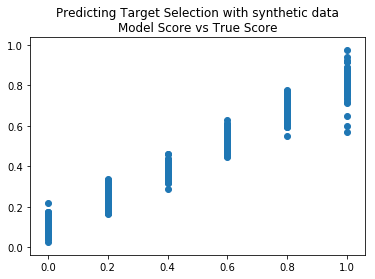

In [368]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [369]:
stats.spearmanr(true_scores_grouped_v1_s, model_scores_grouped_v1_s)

SpearmanrResult(correlation=0.982076573276505, pvalue=0.0)

In [345]:
dev_data_synth[5017].target_idx

0

In [328]:
synth_data[0].index

3

In [331]:
dev_data.data.head()

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,2641-2,1.476490e+12,1,split,target,48,13,50,2,1,...,1.476490e+12,speaker,gray,619.0,1.0,1,4,4.0,1.0,human
1,2641-2,1.476490e+12,2,split,target,66,26,50,3,3,...,1.476490e+12,speaker,green,619.0,1.0,1,5,5.0,1.0,human
2,2641-2,1.476490e+12,3,far,target,336,24,50,2,2,...,1.476490e+12,speaker,lavender ~ the duller one,619.0,1.0,3,12,9.0,2.0,human
3,2641-2,1.476490e+12,4,split,target,172,60,50,1,1,...,1.476490e+12,speaker,the brighter blue,619.0,1.0,3,15,12.0,2.0,human
4,2641-2,1.476490e+12,5,far,target,41,71,50,1,2,...,1.476490e+12,speaker,yellow,619.0,1.0,1,6,6.0,1.0,human


In [315]:
len(synth_data)/50/6

86.0

In [308]:
condition_counter_correct//3

4320

In [304]:
[len(x) for x in fake_entries]

[10254, 8640, 4718]

In [305]:
[len(x) for x in correct_entries]

[5127, 4320, 4718]

In [311]:
(3*4320)

12960

In [75]:
def create_synth_data(fake_entries, correct_entries, num_divisions = 5, filename = "synthdata"):
    synth_data = []
    condition_counter_fake = 0
    condition_counter_correct = 0
    min_condition_samples = 4173 # train # dev - 4320 # we have the fewest number of correct close samples
    num_games = 3*min_condition_samples//((num_divisions + 1) * 25)
    
    # let's divide into fifths
    for i in range(num_divisions + 1): # 0...num_divisions inclusive
        for game_id in range(num_games): # 150 size of each group required over whole game over dataset, 3*4320 
            synth_game = []
            for j in range(50):
                if j < (50/num_divisions) * i: # add fake stuff
                    synth_game.append(fake_entries[condition_counter_fake % 3][condition_counter_fake // 3])
                    condition_counter_fake += 1
                else: # add real stuff
                    synth_game.append(correct_entries[condition_counter_correct % 3][condition_counter_correct // 3])
                    condition_counter_correct += 1
            random.shuffle(synth_game)
            synth_data.extend(synth_game)
    
    # construct a dataframe and populate it (this takes a long time)
    synth_data_df = pd.DataFrame(index=list(range(len(synth_data))), columns=dev_data.data.columns)

    for round_counter, sde in enumerate(synth_data):
        idx = sde.index
        game_id = "synth-%d"%(round_counter // 50)
        synth_data_df.loc[round_counter] = dev_data.data.loc[idx]
        synth_data_df.loc[round_counter, "gameid"] = game_id
        synth_data_df.loc[round_counter, "roundNum"] = round_counter % 50 + 1 # they one index rounds so we do the same...
        synth_data_df.loc[round_counter, "outcome"] = sde.outcome
        synth_data_df.loc[round_counter, "numOutcome"] = 1 if sde.outcome else 0
        
    with open("../data/entries/%s.pkl"%filename, "wb") as pkl_file:
        pkl.dump(synth_data, pkl_file)
    synth_data_df.to_csv("../data/csv/%s.csv"%filename, header=True, index=False)
    monroe_synth_data = MonroeData("../data/csv/%s.csv"%filename, "../data/entries/%s.pkl"%filename)
    return monroe_synth_data

In [76]:
dev_data_synth_10 = create_synth_data(fake_entries, correct_entries, num_divisions=10, filename = "dev_corpus_synth_10fold")

NameError: name 'fake_entries' is not defined

In [426]:
feature_handler_5 = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi)

In [427]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v1, output_to_score, score_model)
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

(0.9803888168043288, 0.0)
Accuracy: 0.46336557059961314


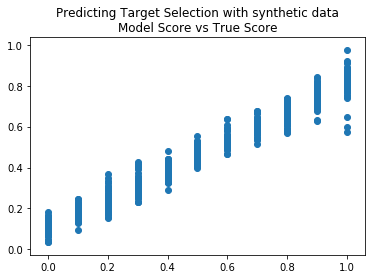

In [428]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [77]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v2, output_to_score, score_model)
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x

(0.965577233389709, 2.3575895002472486e-303)
Accuracy: 0.43705996131528047


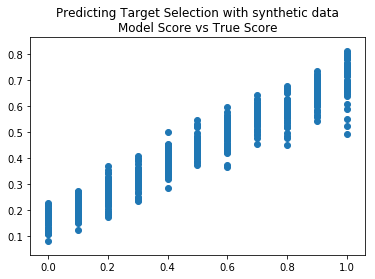

In [78]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [447]:
random.random()

0.7328506028564533

In [434]:
def generate_synth_entries(monroe_df):
    # get correct entries
    correct_entries = list(filter(lambda de: de.target_idx == de.click_idx, monroe_df.entries))
    
    fake_far_entries   = []
    fake_close_entries = []
    fake_split_entries = []
    
    for de in correct_entries:
        # if close or far, basically symmetric so add both (far fakes will be misleading, close fakes will be ambiguous)
        if de.condition == "far" or de.condition == "close":
            for i in range(1,3):
                de_cp = copy.deepcopy(de)
                de_cp.click_idx = i
                de_cp.colors[0], de_cp.colors[i] = de_cp.colors[i], de_cp.colors[0] # swap target and clicked colors
                #de_cp.target_idx = i # i = 1, 2
                de_cp.outcome = False
                if de.condition == "far":
                    if de.index % 2 == 0:
                        fake_far_entries.append(de_cp)
                    else:
                        fake_far_entries.insert(0, de_cp)
                else: # close
                    if de.index % 2 == 0:
                        fake_close_entries.append(de_cp)
                    else:
                        fake_close_entries.insert(0, de_cp)
        # we have to be a bit more careful, because the fake target really should
        # be the one that is closest to the target
        elif de.condition == "split":
            # get index to lookup in dataframe
            idx = de.index
            de_cp = copy.deepcopy(de)
            de_cp.outcome = False
            click_idx = 2 # assume the close one is the 2nd distractor
            if monroe_df.data["targetD1Diff"][idx] < monroe_df.data["targetD2Diff"][idx]:
                # D1 is the close distractor (and new target) - corresponds to color at index 1
                click_idx = 1
            de_cp.click_idx = click_idx
            de_cp.colors[0], de_cp.colors[click_idx] = de_cp.colors[click_idx], de_cp.colors[0]
            fake_split_entries.append(de_cp)
    
    # we also need the correct versions of these tasks
    correct_entries_cond = [[], [], []]
    cond_map = {"far": 0, "close": 1, "split": 2}
    for de in correct_entries:
        correct_entries_cond[cond_map[de.condition]].append(de)
    return [fake_far_entries, fake_close_entries, fake_split_entries], correct_entries_cond

In [435]:
train_data_synth_fake_entries, train_data_synth_correct_entries = generate_synth_entries(train_data)

In [444]:
train_data_synth_10 = create_synth_data(train_data_synth_fake_entries, train_data_synth_correct_entries, num_divisions=10, filename = "train_corpus_synth_10fold")

In [ ]:
# len(train_data_synth_fake_entries[0])

In [442]:
len(train_data_synth_correct_entries[1])

4173

# Making new metric: Literal Listener

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
dev_data_synth_10 = MonroeData("../data/csv/dev_corpus_synth_10fold.csv", "../data/entries/dev_corpus_synth_10fold.pkl")

In [81]:
eval_df = None
def score_model(test_data, scores, regressor=stats.pearsonr, groupbycond=False):
    """
    Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
    between the scores of the individual games and the scores from the model
    """
    global eval_df
    relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq", "condition",
                        "msgTime", "clkTime", "numCleanWords", "numCleanChars"]
#     if speaker == Speaker.BY_WORKER_ID:
#         relevant_columns.append(Speaker.BY_WORKER_ID.value)

# #     if score == Score.COMPOSITE:
#         # no support for this yet but probably also need:
#         relevant_columns.extend(["contents", "clkTime", "msgTime"])

    eval_df = test_data.data[relevant_columns].copy()
    eval_df["model_scores"] = scores # why we need scores to be in same order as rows

    # true_scores = eval_df.groupby("gameid").numOutcome.mean()
    mean_scores = eval_df.groupby("gameid").numOutcome.mean()
    mean_msgTime = eval_df.groupby("gameid").msgTime.mean()
    mean_clkTime = eval_df.groupby("gameid").clkTime.mean()
    mean_numCleanWords = eval_df.groupby("gameid").numCleanWords.mean()
    mean_numCleanChars = eval_df.groupby("gameid").numCleanChars.mean()
    
    if groupbycond:
        mean_scores = eval_df.groupby(["gameid", "condition"]).numOutcome.mean()
        mean_msgTime = eval_df.groupby(["gameid", "condition"]).msgTime.mean()
        mean_clkTime = eval_df.groupby(["gameid", "condition"]).clkTime.mean()
        mean_numCleanWords = eval_df.groupby(["gameid", "condition"]).numCleanWords.mean()
        mean_numCleanChars = eval_df.groupby(["gameid", "condition"]).numCleanChars.mean()
    
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores

#     if score == score.SIMPLE:
#         # calculate scores as the mean of the number of successful utterances
#         # a speaker has
#         true_scores = eval_df.groupby(speaker.value).numOutcome.mean()
#     else:
#         true_scores = calculate_scores(eval_df, score)

    # calculate a model score
    #model_scores = eval_df.groupby("gameid").model_scores.mean()
    model_scores = eval_df.groupby("gameid").model_scores.mean()
    if groupbycond:
        model_scores = eval_df.groupby(["gameid", "condition"]).model_scores.mean()

    result = regressor(true_scores, model_scores)
    print(result)
    return result, true_scores, model_scores

In [82]:
# literal listener v1
train = False
model_file_v1 = "../model/literal_listener_5epoch_endings_tkn.params"

model_v1 = LiteralListener(CaptionEncoder, num_epochs=5)
model_v1.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file))
    #model_v1.fit(train_features, train_targets)
    #model_v1.save_model(model_file)
else:
    print("Loading pretrained model")
    model_v1.load_model(model_file_v1)

Loading pretrained model


In [83]:
train = False
model_file_v2 = "../model/literal_listener_listener_click_5epoch_endings_tkn.params"

model_v2 = LiteralListener(CaptionEncoder, num_epochs=30)
model_v2.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file_v2))
    model_v2.fit(train_features, train_targets)
    model_v2.save_model(model_file_v2)
else:
    print("Loading pretrained model")
    model_v2.load_model(model_file_v2)

Loading pretrained model


In [84]:
feature_handler_5 = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi)

In [85]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v1, output_to_score, score_model)
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

(0.94470461641517, 1.558215061240238e-251)
(0.94470461641517, 1.558215061240238e-251)
Accuracy: 0.4471953578336557


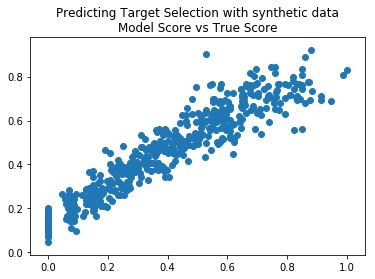

In [86]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [87]:
x2 = evaluate_model(dev_data_synth_10, feature_handler_5, model_v2, output_to_score, score_model)
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x2

(0.9410051220711415, 1.6737074691051348e-244)
(0.9410051220711415, 1.6737074691051348e-244)
Accuracy: 0.43705996131528047


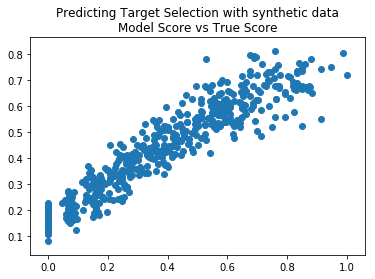

In [88]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

# Pragmatic Listener

In [89]:
#literal listener: use model_v1 trained above

#literal speaker:
epochs=30; color_in_dim = 54; color_dim = 100; embed_dim = 100; hidden_dim = 100; lr = 0.004
ls_model_glove = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=lr, num_epochs=epochs)
ls_model_glove.init_model(color_in_dim=color_in_dim, color_dim=color_dim,
                  vocab_size=caption_phi.caption_indexer.size, embed_dim=embed_dim,
                  speaker_hidden_dim=hidden_dim)
ls_model_glove.load_model("../model/literal_speaker_30epochGLOVE.params")

model_p = PragmaticListener(model_v1, ls_model_glove)

In [90]:
#confirm models are loaded
print(model_v1.predict([train_features[0]]))
# print(model_p.predict([train_features[0]]))

[[ -2.09427118  -0.13143063 -24.25899124]]


In [91]:
feature_handler_5_listener = feature_handler_5
color_phi_speaker = ColorFeaturizer(color_phi_fourier, "hsv", normalized=True)
feature_handler_5_speaker = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi_speaker)
xp = evaluate_model(dev_data_synth_10, feature_handler_5_listener, model_p, output_to_score, score_model, feature_handler_2=feature_handler_5_speaker)

(0.9477390600543572, 1.1320071833501604e-257)
(0.9477390600543572, 1.1320071833501604e-257)
Accuracy: 0.44804642166344294


In [92]:
assess_targets_tgt_p_s, model_outputs_p_s, model_scores_p_s, true_scores_grouped_p_s, model_scores_grouped_p_s = xp

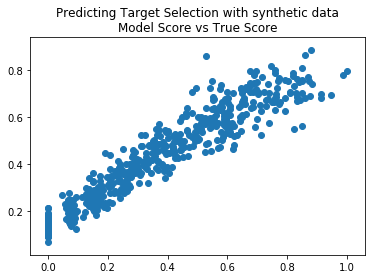

In [93]:
plt.scatter(true_scores_grouped_p_s, model_scores_grouped_p_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [98]:
model_p2 = PragmaticListener(model_v1, ls_model_glove, sample=8)

In [99]:
xp2 = evaluate_model(dev_data_synth_10, feature_handler_5_listener, model_p2, output_to_score, score_model, feature_handler_2=feature_handler_5_speaker)

(0.9473983309536382, 5.770109621369871e-257)
(0.9473983309536382, 5.770109621369871e-257)
Accuracy: 0.4480851063829787


In [100]:
assess_targets_tgt_p2_s, model_outputs_p2_s, model_scores_p2_s, true_scores_grouped_p2_s, model_scores_grouped_p2_s = xp2

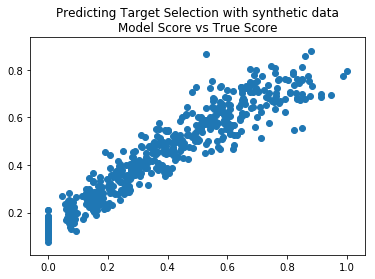

In [101]:
plt.scatter(true_scores_grouped_p2_s, model_scores_grouped_p2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

# Imaginative Listener

In [112]:
from skimage import io, color

In [102]:
# Model 3: third simplest version of the model - generate target color from description AND distractors
# (but just use fully connected layers rather than an RNN to encode the colors
class ColorGeneratorWithDistractorsLinear(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim, weight_matrix=None):
        super(ColorGeneratorWithDistractorsLinear, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        if weight_matrix is not None:
            self.embed.load_state_dict({'weight': weight_matrix})
            
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # Linear layers for colors
        #self.color_rnn = nn.RNN(color_in_dim, color_hidden_dim, bidirectional=True, batch_first=True)
        self.color_encode = nn.Linear(2*color_in_dim, color_hidden_dim)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim + color_hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        self.color_hidden_dim = color_hidden_dim
        
    def forward(self, caption, colors):
        # get caption encodings
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        
        # get color encodings
        colors = colors.reshape(1, 1, -1)
        color_encodings = nn.functional.relu(self.color_encode(colors))
        color_encodings = color_encodings.squeeze(0)
        
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)

        # combine colors and caption
        combined_output = torch.cat((output, color_encodings), 1)
        output = self.linear1(combined_output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output

In [93]:
class ImaginativeListener(PytorchModel):
    def __init__(self, model, use_color=True, **kwargs):
        super(ImaginativeListener, self).__init__(model, **kwargs)
        self.use_color = use_color
        
    def train_iter(self, caption_tensor, color_tensor, target_tensor, optimizer, criterion):
        optimizer.zero_grad()
        loss = 0
        
        # not using colors at the moment
        if self.use_color:
            color_tensor = color_tensor[:, 1:3, :] # don't include the target at index 0
            model_output = self.model(caption_tensor, color_tensor)
        else:
            model_output = self.model(caption_tensor)
            
        if isinstance(criterion, nn.MSELoss):
            loss += criterion(model_output, target_tensor.type(torch.FloatTensor))
        else:
            model_output = model_output.type(torch.DoubleTensor)
            label = torch.tensor(1, dtype=torch.double)
            loss += criterion(model_output, target_tensor.detach(), label)
        loss.backward()
        optimizer.step()
        
        return loss
        
    def predict(self, X):
        model_outputs = np.empty([len(X), 3])
        self.model.eval()
        with torch.no_grad():
            for i, feature in enumerate(X):
                caption, colors = feature
                caption_tensor = torch.tensor([caption], dtype=torch.long)
                color_tensor = torch.tensor([colors], dtype=torch.float)
                if self.use_color:
                    color_tensor = color_tensor[:, 1:3, :] # don't include the target
                    model_output = self.model(caption_tensor, color_tensor)
                else:
                    model_output = self.model(caption_tensor)
                    
                model_output_np = model_output.view(-1).numpy()
                model_outputs[i] = model_output_np
        return np.array(model_outputs)

In [117]:
# author: Chris Potts
def glove2dict(src_filename):
    """GloVe Reader.
    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.
    Returns
    -------
    dict
        Mapping words to their GloVe vectors.
    """
    data = {}
    with open(src_filename, encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line.strip().split()
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

In [125]:
def assess_model(model):
    # get model outputs
    assess_model_outputs = model.predict(assess_features)
    
    # first do delta e check
    assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)
    _, close_scores, split_scores, far_scores, all_scores = score_model(dev_data_synth, assess_model_scores, score=Score.CONDITION, return_df=True)
#     plt.scatter(true_scores_grouped, model_scores_grouped)
#     plt.show()
    
    # next do accuracy check
    assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)
    _, close_scores_eval, split_scores_eval, far_scores_eval, all_scores_eval = score_model(dev_data_synth, assess_model_scores_eval, score=Score.CONDITION, return_df=True)
    close_scores["model_scores_eval"] = close_scores_eval["model_scores"]
    split_scores["model_scores_eval"] = split_scores_eval["model_scores"]
    far_scores["model_scores_eval"] = far_scores_eval["model_scores"]
    all_scores["model_scores_eval"] = all_scores_eval["model_scores"]
    
    close_scores = close_scores.groupby("gameid").mean()
    split_scores = split_scores.groupby("gameid").mean()
    far_scores = far_scores.groupby("gameid").mean()
    all_scores = all_scores.groupby("gameid").mean()
    
    find_correlation(close_scores, "red", "Close")
    find_correlation(split_scores, "blue", "Split")
    find_correlation(far_scores, "green", "Far")
    find_correlation(all_scores, "black", "All")
    
    # all_scores_eval['model_outputs'] = assess_model_outputs
    return all_scores_eval, assess_model_outputs
    
#     plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)
#     plt.show()

In [118]:
glove100 = glove2dict("../../cs224u/data/glove.6B/glove.6B.100d.txt")

In [119]:
# from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
weight_matrix = np.empty((feature_handler.caption_featurizer.caption_indexer.size, 100))
for i, word in feature_handler.caption_featurizer.caption_indexer.idx2word.items():
    weight_matrix[i] = glove100.get(word, np.random.normal(scale=0.6, size=(100, )))

In [120]:
MSELossSum = lambda: nn.MSELoss(reduction='sum')
model_im_glove = ImaginativeListener(ColorGeneratorWithDistractorsLinear, criterion=MSELossSum, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
model_im_glove.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                color_in_dim=54, color_hidden_dim=100, weight_matrix=torch.tensor(weight_matrix))

In [122]:
train = False
model_file_im_glove = "../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params"

if train:
    print("Training model and saving to {}:".format(model_file))
    model_im_glove.fit(train_features, train_targets)
    model_im_glove.save_model(model_file_im2)
else:
    print("Loading pretrained model")
    model_im_glove.load_model(model_file_im2)

Loading pretrained model


In [109]:
output_to_score_cosine = lambda output, target: 2 - scipy.spatial.distance.cosine(output, target)
output_to_score_de = lambda output, target: delta_e_dist(output, target)

def delta_e_dist(color1, color2):
    """color1 and color2 are in rgb space"""
    # do some nice integer conversions
    color1 = np.round(255*color1)
    color2 = np.round(255*color2)
    # convert colors to lab
    color1_lab = color.rgb2lab(np.array([[color1]], dtype=np.uint8)).flatten()
    color2_lab = color.rgb2lab(np.array([[color2]], dtype=np.uint8)).flatten()
    
    # compute Delta E CIEDE 2000 distance
    return color.deltaE_ciede2000(color1_lab, color2_lab)

In [130]:
def all_color_target(data_entry):
    color_array, _ = color_phi.to_color_lists(data_entry.colors, normalized=True)
    return np.array(color_array)

feature_handler_eval = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi, target_fn=all_color_target,
                                randomized_colors=False)

In [132]:
def output_to_score_closest_color(model_output, target):
    distances = np.array([delta_e_dist(model_output, color) for color in target])
    return np.argmin(distances) == 0 # target is closest

In [131]:
assess_features = feature_handler_eval.test_features()
assess_targets = feature_handler_eval.test_targets()

In [133]:
# using closest color
assess_model_scores = [output_to_score_closest_color(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]

In [175]:
# using de
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]

In [138]:
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth_10, assess_model_scores)

(0.8564912607001747, 4.981924900611038e-150)


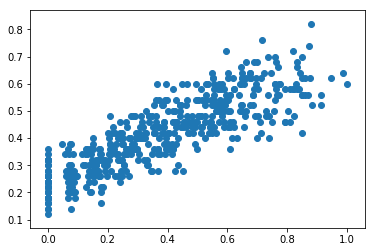

In [139]:
plt.scatter(true_scores_grouped, model_scores_grouped)

# Visualize with Conditions

In [176]:
relevant_columns = ["gameid", "roundNum", "numOutcome", "condition"]
eval_df = dev_data_synth_10.data[relevant_columns].copy()

_, true_scores_grouped_cond, model_scores_grouped_cond = score_model(dev_data_synth_10, assess_model_scores, groupbycond=True)

# eval_df["model_scores_dlg"] = assess_model_scores
# eval_scores_split = eval_df.groupby(['gameid', 'condition']).mean()

(-0.19963098394232448, 2.0933882749803276e-15)


In [177]:
colors = []
for cond in true_scores_grouped_cond.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

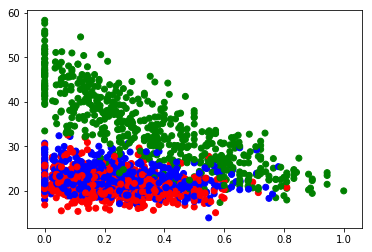

In [179]:
# Imaginative listener eval results by conditions
plt.scatter(true_scores_grouped_cond, model_scores_grouped_cond, c=colors)
plt.show()

In [181]:
relevant_columns = ["gameid", "roundNum", "numOutcome", "condition"]
eval_df_lit = dev_data_synth_10.data[relevant_columns].copy()

_, true_scores_grouped_cond, model_scores_grouped_cond = score_model(dev_data_synth_10, model_scores_v2_s, groupbycond=True)

# eval_df_lit["model_scores_dlg"] = model_scores_v2_s
# eval_scores_split_lit = eval_df_lit.groupby(['gameid', 'condition']).mean()

(0.836993221752449, 0.0)


In [182]:
colors = []
for cond in true_scores_grouped_cond.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

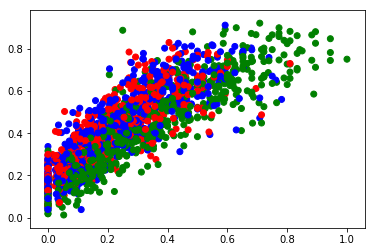

In [183]:
# Literal listener v2 eval results by conditions
plt.scatter(true_scores_grouped_cond, model_scores_grouped_cond, c=colors)
plt.show()